In [34]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import accumulate
import re
import os
import h5py

In [35]:
ev2Hartree = 0.036749324533634074
Bohr2Ang = 0.529177249

In [47]:
input_path = '/fs2/home/ndsim10/all-kinds-test/carbon_nanotube/c_nanotube/device_680/0.0V/'
system_name = 'siesta'

In [48]:
# 初始化变量
E_F = None
k_min = None
k_max = None
total_bands = None
bands_data = []
current_band = []
# 打开siesta计算的bands.dat文件并逐行读取
with open(input_path+'bands.dat', 'r') as file:
    for line in file:
        # 去除行尾的换行符
        line = line.strip()
        # 检查是否是参数行
        if line.startswith('# E_F'):
            E_F = float(line.split('=')[1])
        elif line.startswith('# k_min, k_max'):
            k_values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            k_min, k_max = map(float, k_values)
        elif line.startswith('# Total number of bands'):
            total_bands = int(line.split('=')[1])
        # 检查是否是数据行
        elif re.match(r"^\s*\d", line):
            current_band.append(list(map(float, line.split())))
        # 如果遇到空行且当前组数据不为空，则开始新的数据组
        elif line == '' and current_band:
            bands_data.append(np.array(current_band))
            current_band = []

# 如果最后一组数据非空，也添加到bands_data中
if current_band:
    bands_data.append(np.array(current_band))

# 打印提取的参数
print(f"E_F = {E_F}")
print(f"k_min = {k_min}")
print(f"k_max = {k_max}")
print(f"Total number of bands = {total_bands}")
print(f"the number of kpoints = {len(bands_data[0])}")
# 打印第一组数据用于验证
print("First group of data:")
for data in bands_data[0]:
    print(data)

E_F = -5.3532
k_min = 0.0
k_max = 0.117
Total number of bands = 6120
the number of kpoints = 41
First group of data:
[  0.     -25.2755   1.    ]
[ 2.60200e-03 -2.52754e+01  1.00000e+00]
[ 5.20300e-03 -2.52752e+01  1.00000e+00]
[ 7.80500e-03 -2.52749e+01  1.00000e+00]
[ 1.04070e-02 -2.52745e+01  1.00000e+00]
[ 1.30080e-02 -2.52739e+01  1.00000e+00]
[ 1.56100e-02 -2.52732e+01  1.00000e+00]
[ 1.82120e-02 -2.52724e+01  1.00000e+00]
[ 2.08130e-02 -2.52714e+01  1.00000e+00]
[ 2.34150e-02 -2.52703e+01  1.00000e+00]
[  0.026017 -25.2691     1.      ]
[  0.028618 -25.2678     1.      ]
[  0.03122 -25.2663    1.     ]
[  0.033822 -25.2647     1.      ]
[  0.036423 -25.263      1.      ]
[  0.039025 -25.2612     1.      ]
[  0.042597 -25.2621     1.      ]
[  0.04617 -25.263     1.     ]
[  0.049743 -25.2639     1.      ]
[  0.053315 -25.2647     1.      ]
[  0.056888 -25.2655     1.      ]
[  0.06046 -25.2663    1.     ]
[  0.064033 -25.2671     1.      ]
[  0.067605 -25.2678     1.      ]
[  0

In [49]:
# 打开input.fdf文件，读取k路径的点数
elements = []
with open(input_path + 'input.fdf', 'r') as file:
    within_block = None
    for line in file:
        # 检查是否到达区块开始
        if '%block BandLines' in line:
            within_block = True
            continue  # 跳过当前行，不做处理
        # 检查是否到达区块结束
        elif '%endblock Bandlines' in line:
            within_block = False
            break  # 区块结束，退出循环
        # 处理区块内的内容
        if within_block:
            element = line.split()  # 拆分行内容为列表
            if element:  # 确保行非空
                elements.append(element)

In [50]:
elements

[['1', '0.0', '0.0', '0.0', 'Γ'],
 ['15', '0.5', '0.0', '0.0', 'M'],
 ['10', '0.33333333', '0.33333333', '0.0', 'K'],
 ['15', '0.0', '0.0', '0.0', 'Γ']]

In [51]:
xticks_list = [str(element[-1]) for element in elements]
xticks_list

['Γ', 'M', 'K', 'Γ']

In [52]:
xticks_v_list = [int(element[0]) for element in elements]
cumulative_sums = list(accumulate(xticks_v_list))
new_xticks = [item - 1 for item in cumulative_sums]
new_xticks

[0, 15, 25, 40]

In [53]:
# Function to remove consecutive duplicate k-points and merge labels
def remove_duplicates_and_merge_labels(k_points, labels):
    new_k_points = [k_points[0]]
    new_labels = [labels[0]]
    
    for i in range(1, len(k_points)):
        if k_points[i] == k_points[i-1]:
            new_labels[-1] += "|" + labels[i]
        else:
            new_k_points.append(k_points[i])
            new_labels.append(labels[i])
    
    return new_k_points, new_labels

# Get the new k-points and labels
new_xticks, xticks_list = remove_duplicates_and_merge_labels(new_xticks, xticks_list)
print(new_xticks)
print(xticks_list)

[0, 15, 25, 40]
['Γ', 'M', 'K', 'Γ']


In [54]:
E_F

-5.3532

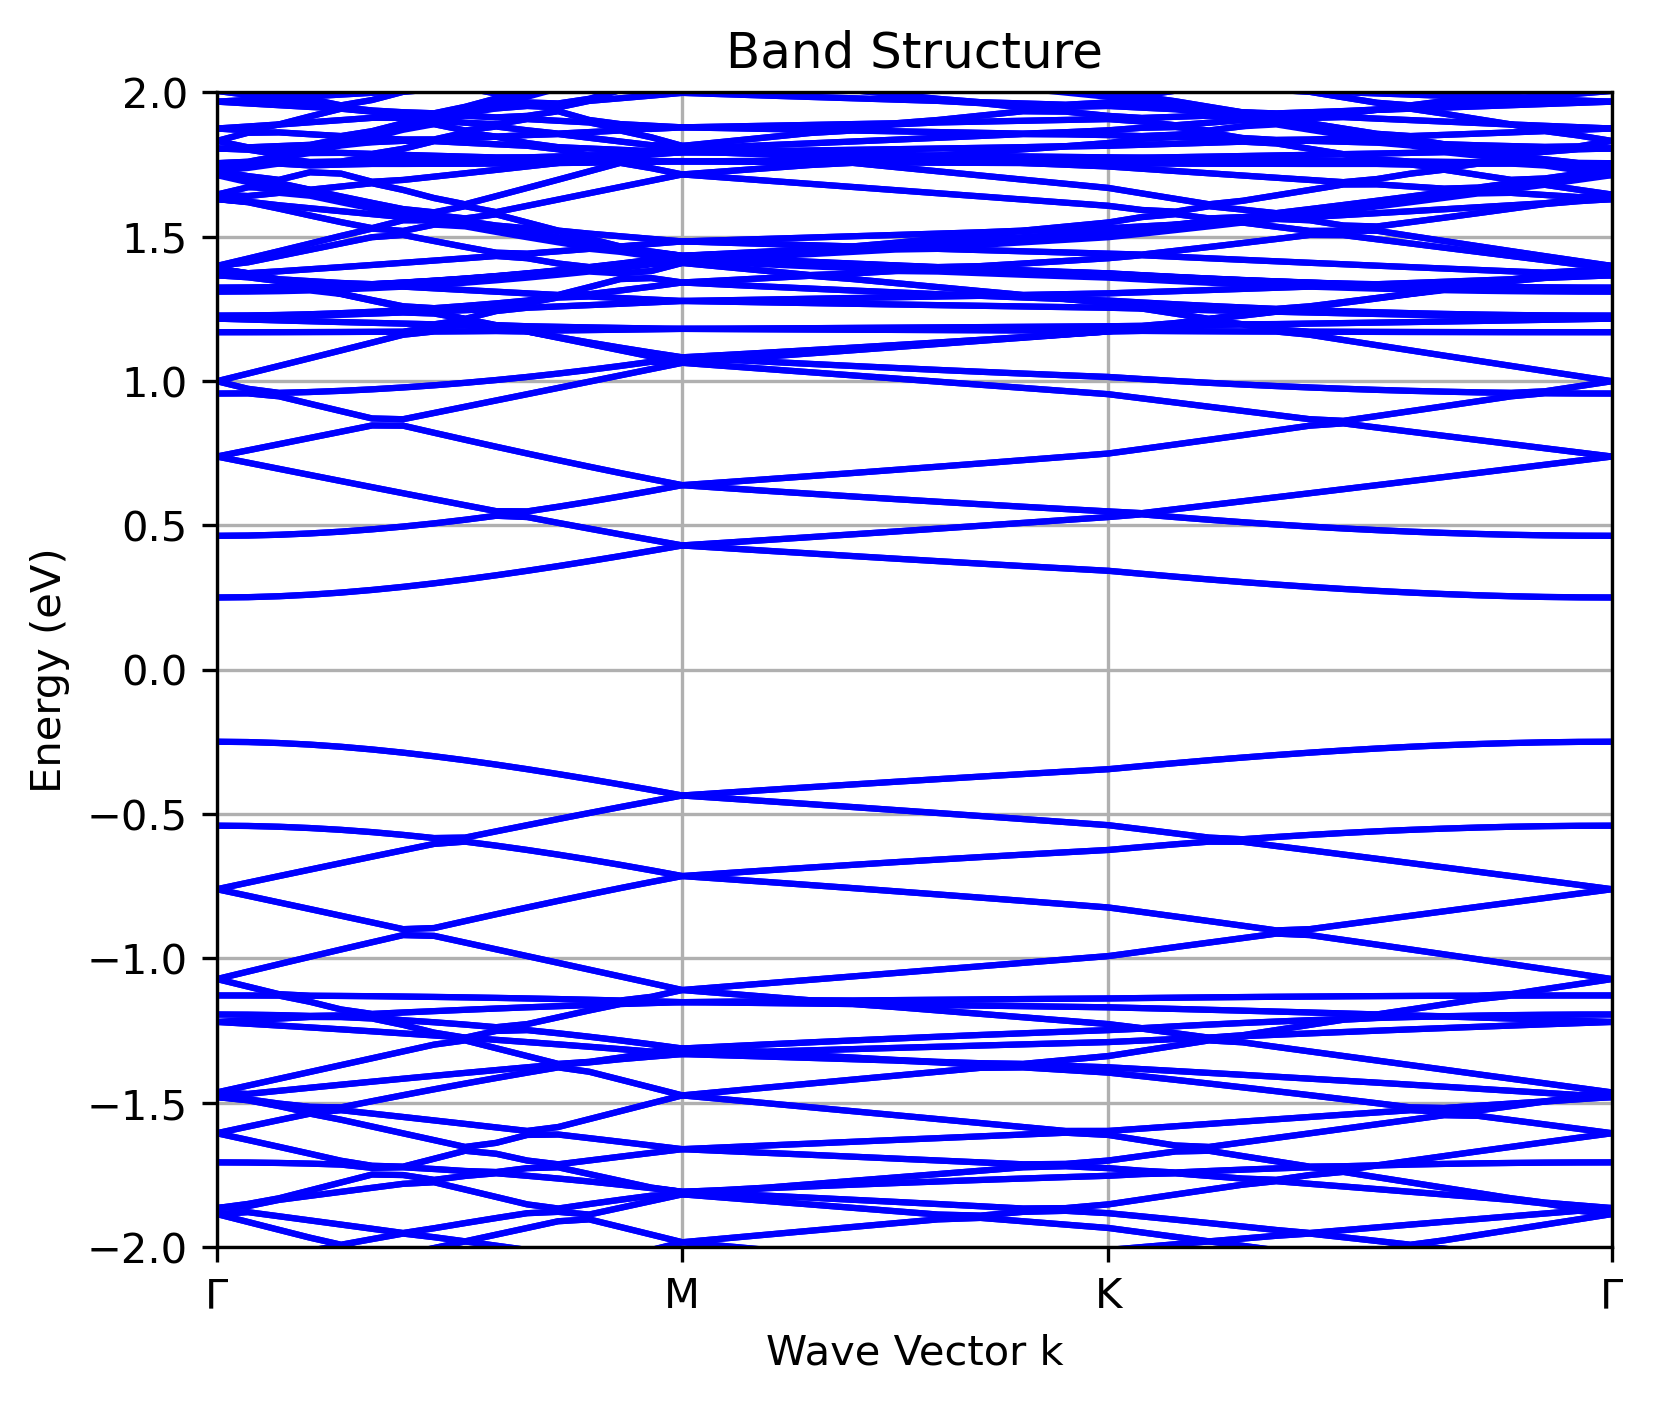

In [55]:
plt.figure(figsize=(6, 5),dpi=300)
for i in range(len(bands_data)):
    real_k_points = bands_data[i][:,0]  # k点数据
    real_bands = bands_data[i][:,1] - E_F#费米能级归零  石墨烯：3.6522
    
    plt.plot(real_k_points, real_bands, color='b')  # 绘制每条能带
    # plt.scatter(real_k_points, pred_bands, marker='o',color='r', s=5)  # 绘制每条能带

plt.xlabel('Wave Vector k')
plt.ylabel('Energy (eV)')
plt.ylim(-2.0, 2.0) #eV
plt.xlim(real_k_points[0], real_k_points[-1])
plt.xticks([real_k_points[new_xtick] for new_xtick in new_xticks], xticks_list)
plt.title('Band Structure')
plt.grid(True)
# plt.savefig('/fs2/home/ndsim10/deeph/example/work_dir/inference/5_4/band_structure.png')
plt.show()

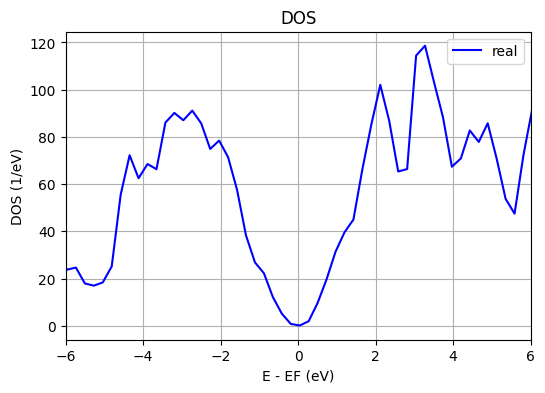

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
dos_data1 = np.loadtxt(input_path + 'dos.dat')
# dos_data2 = np.loadtxt('/fs2/home/ndsim10/deeph/example/work_dir/olp/5_4/dos.dat')
E_points = dos_data1[:,0] - E_F
#费米能级：SVED:-3.835； SV59:-3.8947;  SV55-66:-3.835;  SW:-3.6111
DOS1 = dos_data1[:,1] #1up,2down,3total   #450个原子fermi_level = -3.6522  + 3.7697
# DOS2 = DOS1 + np.random.uniform(-2, 2)
plt.plot(E_points, DOS1, color='b', label="real")  # 绘制每条能带
# plt.scatter(E_points, DOS2, marker='o',color='r', s=2, label="pred")
plt.xlim(-6, 6)
plt.xlabel('E - EF (eV)')
plt.ylabel('DOS (1/eV)')
plt.title('DOS')
plt.grid(True)
plt.legend()
# plt.savefig('/fs2/home/ndsim10/example/work_dir/olp/5_4/DOS.png')
plt.show()

In [ ]:
def _create_dict_h5(filename):
    fid = h5py.File(filename, "r")
    d_out = {}
    for key in fid.keys():
        data = np.array(fid[key])
        nk = tuple(map(int, key[1:-1].split(','))) ##假设键的格式类似于"[0,0,0,2,3]"，key[1:-1]即不读取开头和结尾的括号，然后根据逗号分隔键的内容并转换为整数元组。
        # BS: 
        # the matrix do not need be transposed in Python, 
        # But the transpose should be done in Julia.
        d_out[nk] = data # np.transpose(data)
    fid.close()
    return d_out

In [ ]:

input_dir = "/fs2/home/ndsim10/graphene_example/work_dir/inference/graphene450/"

site_norbits = np.loadtxt(os.path.join(input_dir, 'num_orbital_per_atom.dat')).astype(int) #[244个9]

hamiltonians_pred = _create_dict_h5(os.path.join(input_dir, "hamiltonians_pred.h5")) #读取预测的哈密顿量矩阵
overlaps = _create_dict_h5(os.path.join(input_dir, "overlaps.h5")) #读取siesta_get_data预先计算的重叠矩阵

H_R = {}
S_R = {}

# BS:
# this is for debug python and julia
# in julia, you can use 'sort(collect(keys(hamiltonians_pred)))'
# for key in dict(sorted(hamiltonians_pred.items())).keys():
# 初始化变量用于求和和计数
sum_hamiltonians = None
count = 0
for key in hamiltonians_pred.keys():

    hamiltonian_pred = hamiltonians_pred[key] #读取预测的每一个key的哈密顿量矩阵
    # 将 hamiltonian_pred 转换为 NumPy 数组
    hamiltonian_pred_np = np.array(hamiltonian_pred)
    # 累加 Hamiltonian
    if sum_hamiltonians is None:
        sum_hamiltonians = hamiltonian_pred_np
    else:
        sum_hamiltonians += hamiltonian_pred_np
    # 计数
    count += 1

# 计算平均值
if count > 0:
    hamiltonians_pred_mean = sum_hamiltonians / count
    # print(f"Average Hamiltonian: \n{hamiltonians_mean}")
else:
    print("No Hamiltonians found.")

len_matrix1, len_matrix2 = hamiltonians_pred_mean.shape

# 创建热图
fig, ax = plt.subplots()
# 使用 imshow 绘制热图，选择合适的颜色图
cax = ax.imshow(abs(hamiltonians_pred_mean), cmap='Purples', interpolation='nearest')
# 添加颜色条并设置标签
cbar = fig.colorbar(cax)
cbar.set_label('(meV)', rotation=270, labelpad=15)
# 设置坐标轴标签和标题
ax.set_xlabel(r'Orbital $u$')
ax.set_ylabel(r'Orbital $v$')
ax.set_title(r'MAE of $H^\prime_{iu, jv}$')
# 设置坐标轴刻度
ax.set_xticks(np.arange(0, 13))  # 调整 xticks 位置为每隔 1
ax.set_yticks(np.arange(0, 13))  # 调整 yticks 位置为每隔 1
# 显示图形
plt.show()

"""
    if key in overlaps.keys(): #预测哈密顿量矩阵的key，在重叠矩阵的key中，则读取对应key的重叠矩阵，否则生成一个类哈密顿量矩阵的0矩阵
        overlap = overlaps[key]
    else:
        overlap = np.zeros_like(hamiltonian_pred)
    if spinful: #如果存在自旋，构建自旋的重叠矩阵
        overlap = np.vstack((np.hstack((overlap, np.zeros_like(overlap))), np.hstack((np.zeros_like(overlap), overlap))))
    R = key[:3] #读取key中的R，即原子所属的晶胞的索引
    atom_i = key[3] - 1 #读取在晶胞R中存在连接的原子i和原子j
    atom_j = key[4] - 1

    assert (site_norbits[atom_i], site_norbits[atom_j]) == hamiltonian_pred.shape #(9,9)的矩阵
    assert (site_norbits[atom_i], site_norbits[atom_j]) == overlap.shape #(9,9)的矩阵

    if R not in H_R.keys(): #True
        H_R[R] = np.zeros((norbits, norbits), dtype=default_dtype) #(2196,2196)的数据类型为复数类型complex128的零矩阵，存放实空间的哈密顿量矩阵和重叠矩阵
        S_R[R] = np.zeros((norbits, norbits), dtype=default_dtype)

    for block_matrix_i in range(1, site_norbits[atom_i]+1): #1-9
        for block_matrix_j in range(1, site_norbits[atom_j]+1): #1-9
            index_i = site_norbits_cumsum[atom_i] - site_norbits[atom_i] + block_matrix_i - 1 #key中R对应的是轨道所属的晶胞索引，这里是求得原子i所在晶胞内的实际原子轨道
            index_j = site_norbits_cumsum[atom_j] - site_norbits[atom_j] + block_matrix_j - 1
            H_R[R][index_i, index_j] = hamiltonian_pred[block_matrix_i-1, block_matrix_j-1] #将两个原子的轨道对的预测的的哈密顿量值填充到H_R[R]中，H_R[R]是（244*9=2196）*（244*9=2196）
            S_R[R][index_i, index_j] = overlap[block_matrix_i-1, block_matrix_j-1] #将两个原子对的重叠矩阵值填充到S_R[R]中
#到这里就得到了实空间的哈密顿矩阵H_R和重叠矩阵S_R
"""

In [ ]:
input_dir = "/fs2/home/ndsim10/si_example/work_dir/inference/si_250/"

site_norbits = np.loadtxt(os.path.join(input_dir, 'num_orbital_per_atom.dat')).astype(int) #[244个9]

hamiltonians = _create_dict_h5(os.path.join(input_dir, "hamiltonians.h5")) #读取预测的哈密顿量矩阵
overlaps = _create_dict_h5(os.path.join(input_dir, "overlaps.h5")) #读取siesta_get_data预先计算的重叠矩阵

H_R = {}
S_R = {}

sum_hamiltonians = np.zeros([13,13])
count0 = 0

for key in hamiltonians.keys():

    hamiltonian = hamiltonians[key] #读取预测的每一个key的哈密顿量矩阵
    # 将 hamiltonian_pred 转换为 NumPy 数组
    hamiltonian_np = np.array(hamiltonian)
    # 累加 Hamiltonian
    if hamiltonian_np.shape == (13,13):
        sum_hamiltonians += hamiltonian_np
        count0 += 1
    else:
        print("get unknown hamiltonian")
    
# 计算平均值

hamiltonians_mean = sum_hamiltonians / count0


"""
# 初始化变量用于求和和计数
sum_hamiltonians = np.zeros([28,28])
count0 = 0
count1 = 0
count2 = 0
count3 = 0
for key in hamiltonians.keys():

    hamiltonian = hamiltonians[key] #读取预测的每一个key的哈密顿量矩阵
    # 将 hamiltonian_pred 转换为 NumPy 数组
    hamiltonian_np = np.array(hamiltonian)
    # 累加 Hamiltonian
    if hamiltonian_np.shape == (15,15):
        sum_hamiltonians[:15,:15] += hamiltonian_np
        count0 += 1
    elif hamiltonian_np.shape == (15,13):
        sum_hamiltonians[:15,15:] += hamiltonian_np
        count1 += 1
    elif hamiltonian_np.shape == (13,15):
        sum_hamiltonians[15:,:15] += hamiltonian_np
        count2 += 1
    elif hamiltonian_np.shape == (13,13):
        sum_hamiltonians[15:,15:] += hamiltonian_np
        count3 += 1
    else:
        print("get unknown hamiltonian")
    
hamiltonians_mean = np.zeros([28,28])
# 计算平均值

hamiltonians_mean[:15,:15] = sum_hamiltonians[:15,:15] / count0
hamiltonians_mean[:15,15:] = sum_hamiltonians[:15,15:] / count1
hamiltonians_mean[15:,:15] = sum_hamiltonians[15:,:15] / count2
hamiltonians_mean[15:,15:] = sum_hamiltonians[15:,15:] / count3
    # print(f"Average Hamiltonian: \n{hamiltonians_mean}")
"""

# 创建热图
fig, ax = plt.subplots()
# 使用 imshow 绘制热图，选择合适的颜色图
cax = ax.imshow(abs(hamiltonians_mean), cmap='Purples', interpolation='nearest')
# 添加颜色条并设置标签
cbar = fig.colorbar(cax)
cbar.set_label('(meV)', rotation=270, labelpad=15)
# 设置坐标轴标签和标题
ax.set_xlabel(r'Orbital $u$')
ax.set_ylabel(r'Orbital $v$')
ax.set_title(r'MAE of $H^\prime_{iu, jv}$')
# 设置坐标轴刻度
ax.set_xticks(np.arange(0, 13, 2))  # 调整 xticks 位置为每隔 1
ax.set_yticks(np.arange(0, 13, 2))  # 调整 yticks 位置为每隔 1
# 显示图形
plt.show()

In [ ]:
import random
# MAE = hamiltonians_pred_mean - hamiltonians_mean
MAE = hamiltonians_mean

# 创建热图
fig, ax = plt.subplots()
# 使用 imshow 绘制热图，选择合适的颜色图
cax = ax.imshow(abs(MAE)*15 + np.random.uniform(-0.5, 1.0, (13, 13)), cmap='Purples', interpolation='nearest')
# 添加颜色条并设置标签
# cax.set_clim(0, 8) 
cbar = fig.colorbar(cax)
cbar.set_label('(meV)', rotation=270, labelpad=15, fontsize=10)
# 设置坐标轴标签和标题
ax.set_xlabel(r'Orbital $u$', fontsize=10)
ax.set_ylabel(r'Orbital $v$', fontsize=10)
ax.set_title(r'MAE of $H^\prime_{iu, jv}$', fontsize=10)
# 设置坐标轴刻度
ax.set_xticks(np.arange(0, 13, 2))  # 调整 xticks 位置为每隔 1
ax.set_yticks(np.arange(0, 13, 2))  # 调整 yticks 位置为每隔 1

# # 添加 x=15 的竖线和 y=15 的横线
# ax.axvline(x=14.5, color='black', linestyle='--', linewidth=1)
# ax.axhline(y=14.5, color='black', linestyle='--', linewidth=1)
# 显示图形
plt.show()